In [1]:
# Modelo YOLO Version 3 para detección de objetos (celdas de sangre)
# Basado en el repositorio de Manuel Garcia UEM Junio 2025

#1. Reproducibilidad total

import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f"Semilla global fijada en {SEED}")

Semilla global fijada en 42


In [2]:
# Modelo YOLO Version 3 para detección de objetos (celdas de sangre)
# Basado en el repositorio de Manuel Garcia UEM Junio 2025

# Ruta al repositorio 
# C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/

# Ruta al fichero de configuracion yolov3.cfg
#C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/config

# Ruta a los pesos preentrenados yolov3.weights
# C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/weights/

# Importamos librerias

import torch
import torch.nn as nn
import sys
import os
import numpy as np 

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from sklearn.model_selection import train_test_split

import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm 

print("Liberias importadas correctamente")

#from yolov3_model_setup_V2_genie_OK import model, device  # Debe devolver el modelo ya adaptado y en el device
#from yolov3_dataset_setup_V4_genie_OK import BloodCellDataset, train_transforms, val_test_transforms, YOLO_INPUT_SIZE
#from yolov3_IOU_loss_function_V2_genie_OK import YOLOv3Loss


Liberias importadas correctamente


In [3]:
# Verificamos que PyTorch está instalado y la versión
print(f"Versión de PyTorch: {torch.__version__}")

# Verificamos que NumPy está instalado y la versión
print(f"Versión de NumPy: {np.__version__}")

# Verificamos que sys está instalado y la versión
print(f"Versión de sys: {sys.version}")
# Verificamos que os está instalado y la versión
print(f"Versión de os: {os.name}")
# Verificamos que la GPU está disponible (si es que se va a usar)
if torch.cuda.is_available():
    print("GPU disponible para PyTorch.")
    print(f"Dispositivo actual: {torch.cuda.get_device_name(0)}")
else:
    print("No se detecta GPU, se usará la CPU para el entrenamiento.")


Versión de PyTorch: 2.3.1
Versión de NumPy: 1.26.4
Versión de sys: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Versión de os: nt
No se detecta GPU, se usará la CPU para el entrenamiento.


In [4]:
# Configuración de rutas
# Ruta donde hemos clonado el repositorio de Erik Lindernoren.
YOLOV3_REPO_PATH = 'C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/'
YOLOV3_MODELS_PATH = os.path.join(YOLOV3_REPO_PATH, 'pytorchyolo')
print(f"Ruta del repositorio YOLOv3: {YOLOV3_REPO_PATH}")
print(f"Ruta de los modelos YOLOv3: {YOLOV3_MODELS_PATH}")

# Rutas de Archivos Específicos
# Archivo de configuracion yolov3.cfg
CONFIG_PATH = os.path.join(YOLOV3_REPO_PATH, 'config', 'yolov3.cfg')
CONFIG_PATH = CONFIG_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac
print(f"Ruta del archivo de configuración YOLOv3: {CONFIG_PATH}")

# Archivo de pesos .weights descargado de https://github.com/patrick013/Object-Detection---Yolov3.git
WEIGHTS_PATH = os.path.join(YOLOV3_REPO_PATH, 'yolov3.weights')
WEIGHTS_PATH = WEIGHTS_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac
print(f"Ruta del archivo de pesos YOLOv3: {WEIGHTS_PATH}")

# Añadimos esta ruta al PYTHONPATH para que Python pueda encontrar los módulos.
sys.path.append(YOLOV3_REPO_PATH)
sys.path.append(YOLOV3_MODELS_PATH)
print(f"Rutas añadidas al PYTHONPATH: {YOLOV3_REPO_PATH} y {YOLOV3_MODELS_PATH}")

# Importamos las clases necesarias del repositorio.
# Darknet y YOLOLayer son las clases principales del modelo.
from models import Darknet, YOLOLayer 

# Detección del Dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Trabajando en el dispositivo: {device}")

Ruta del repositorio YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/
Ruta de los modelos YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/pytorchyolo
Ruta del archivo de configuración YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/config/yolov3.cfg
Ruta del archivo de pesos YOLOv3: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/yolov3.weights
Rutas añadidas al PYTHONPATH: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/ y C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/pytorchyolo
Trabajando en el dispositivo: cpu


In [5]:
# Definicion del modelo
    
# Parámetros Generales
# Número de clases del dataset BCCD (Glóbulos Rojos, Glóbulos Blancos, Plaquetas).
NUM_CLASSES_YOUR_DATASET = 3
# Tamaño de la imagen de entrada para el modelo YOLOv3 (típicamente 416x416 o 608x608).
IMG_SIZE = 416 

# Definimos los anchor masks para tus 3 clases (placeholder hasta definir los adecuados con KMeans)
# YOLOv3 usa 9 anchor boxes en total, divididos en 3 grupos de 3 para cada escala.
# Estos son los INDICES de los anchors. Los valores reales los calculaamos con K-Means.
# Ejemplo: si los 9 anchors se ordenan de menor a mayor área, los grandes (indices 6,7,8) van a la escala 13x13.
#Anchor Boxes Calculadas (Formato para YOLOv3Loss): [[(227, 210), (179, 155), (124, 111)], [(105, 113), (104, 96), (80, 109)], [(112, 75), (87, 82), (39, 38)]]

DUMMY_ANCHORS_MASKS = [
    [(227, 210), (179, 155), (124, 111)],  # Anchors para la escala más grande (stride 32, detecta objetos grandes)
    [(105, 113), (104, 96), (80, 109)],    # Anchors para la escala media (stride 16, detecta objetos medianos)
    [(112, 75), (87, 82), (39, 38)]        # Anchors para la escala más pequeña (stride 8, detecta objetos pequeños)
]

# Rutas de Archivos Específicos
# Archivo de configuracion yolov3.cfg
CONFIG_PATH = os.path.join(YOLOV3_REPO_PATH, 'config', 'yolov3.cfg')
CONFIG_PATH = CONFIG_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac

# Archivo de pesos .weights descargado de https://github.com/patrick013/Object-Detection---Yolov3.git
WEIGHTS_PATH = os.path.join(YOLOV3_REPO_PATH, 'yolov3.weights')
WEIGHTS_PATH = WEIGHTS_PATH.replace('\\', '/')  # Asegúrate de usar barras normales para evitar problemas en Linux/Mac

# Detección del Dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Trabajando en el dispositivo: {device}")

# PASO 1: Instanciar el Modelo YOLOv3 (para 80 clases, usando el .cfg original)
# La clase Darknet de Erik Lindernoren construye el modelo leyendo el archivo yolov3.cfg.
# Esto crea el modelo con la arquitectura esperada por el archivo yolov3.weights.
print(f"Cargando la arquitectura del modelo desde: {CONFIG_PATH} (con classes=80)")
model = Darknet(CONFIG_PATH)
model.to(device) # Mueve el modelo al dispositivo (GPU/CPU)
print("Modelo YOLOv3 cargado correctamente en el dispositivo: ", device)

# PASO 2: Cargamos los Pesos Pre-entrenados
# El método load_darknet_weights() es el encargado de leer el archivo yolov3.weights.
try:
    print(f"Intentando cargar pesos pre-entrenados desde: {WEIGHTS_PATH}")
    model.load_darknet_weights(WEIGHTS_PATH)
    print("Pesos pre-entrenados cargados con éxito.")

except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo de pesos en {WEIGHTS_PATH}.")
    print("El modelo se inicializará con pesos aleatorios (NO se usará transfer learning).")
    print("¡ADVERTENCIA! Entrenar desde cero con solo 300 imágenes será extremadamente difícil.")
except Exception as e:
    print(f"ERROR al cargar los pesos pre-entrenados: {e}")
    print("El modelo se inicializará con pesos aleatorios (NO se usará transfer learning).")
    print("¡ADVERTENCIA! Entrenar desde cero con solo 300 imágenes será extremadamente difícil.")

# ... (all your setup code above remains unchanged)

# PASO 3: Adaptacion del modelo para las 3 clases (FINE-TUNING EN MEMORIA)
print("\nAdaptando las capas de predicción a 3 clases...")

yolo_layer_index_in_model_yolo_layers = 0
for i, module_def in enumerate(model.module_defs):
    if module_def["type"] == "yolo":
        pred_conv_sequential_idx = i - 1
        pred_conv_layer_old = model.module_list[pred_conv_sequential_idx][0]
        yolo_layer_old_instance = model.yolo_layers[yolo_layer_index_in_model_yolo_layers]
        new_out_channels = len(yolo_layer_old_instance.anchors) * (5 + NUM_CLASSES_YOUR_DATASET)
        new_pred_conv_layer = nn.Conv2d(pred_conv_layer_old.in_channels, new_out_channels,
                                        kernel_size=pred_conv_layer_old.kernel_size,
                                        stride=pred_conv_layer_old.stride,
                                        padding=pred_conv_layer_old.padding,
                                        bias=True
                                        )
        model.module_list[pred_conv_sequential_idx] = nn.Sequential(new_pred_conv_layer)
        anchors_for_new_layer = yolo_layer_old_instance.anchors.tolist()
        stride_for_new_layer = yolo_layer_old_instance.stride
        new_yolo_layer = YOLOLayer(anchors_for_new_layer, NUM_CLASSES_YOUR_DATASET, new_coords=False)
        model.module_list[i] = nn.Sequential(new_yolo_layer)
        model.yolo_layers[yolo_layer_index_in_model_yolo_layers] = new_yolo_layer
        yolo_layer_index_in_model_yolo_layers += 1

print("Capas YOLOLayer y sus capas de predicción Conv2d adaptadas para 3 clases.")

# --- NUEVA SECCIÓN: CONGELAR TODAS LAS CAPAS, SOLO DESCONGELAR LAS ULTIMAS Conv2d DE PREDICCIÓN ---
print("\nConfigurando capas para Fine-Tuning (solo las capas Conv2d justo antes de cada YOLOLayer serán entrenables):")

# Congelar todos los parámetros por defecto
for param in model.parameters():
    param.requires_grad = False

# Solo las Conv2d antes de YOLOLayer quedan como entrenables
for i, module_def in enumerate(model.module_defs):
    if module_def["type"] == "yolo":
        pred_conv_sequential_idx = i - 1
        conv_seq = model.module_list[pred_conv_sequential_idx]
        # Buscar la capa Conv2d dentro del Sequential
        for layer in conv_seq:
            if isinstance(layer, nn.Conv2d):
                for param in layer.parameters():
                    param.requires_grad = True
                print(f"  Descongelada capa Conv2d antes del YOLOLayer en module_list[{i}]")

# --- Verificación de Capas Entrenables ---
print("\nVerificación de capas que se entrenarán ('requires_grad=True'):")
trainable_params_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        trainable_params_count += param.numel()

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal de parámetros entrenables: {trainable_params_count / 1e6:.2f} M")
print(f"Total de parámetros congelados: {(total_params - trainable_params_count) / 1e6:.2f} M")
print(f"Total de parámetros en el modelo: {total_params / 1e6:.2f} M")

# PASO 5: Prueba Final de la Pasada hacia Adelante (sanity check)
print("\nRealizando una pasada hacia adelante para verificar la configuración del modelo...")

model.eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    predictions = model(dummy_input)

print(f"\nShape de la salida del modelo después de cargar pesos y adaptar a {NUM_CLASSES_YOUR_DATASET} clases (en modo EVAL):")
print(f"  Escala 13x13: {predictions[0].shape} (Esperado: [N, 3*13*13, 5+C])")
print(f"  Escala 26x26: {predictions[1].shape} (Esperado: [N, 3*26*26, 5+C])")
print(f"  Escala 52x52: {predictions[2].shape} (Esperado: [N, 3*52*52, 5+C])")
print(f"¡Las dimensiones de salida para {NUM_CLASSES_YOUR_DATASET} clases son correctas en modo EVAL!\n")
print("\n--- ¡Fase de Configuración del Modelo YOLOv3 Completada Exitosamente! ---")


Trabajando en el dispositivo: cpu
Cargando la arquitectura del modelo desde: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/config/yolov3.cfg (con classes=80)
Modelo YOLOv3 cargado correctamente en el dispositivo:  cpu
Intentando cargar pesos pre-entrenados desde: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/yolov3.weights
Pesos pre-entrenados cargados con éxito.

Adaptando las capas de predicción a 3 clases...
Capas YOLOLayer y sus capas de predicción Conv2d adaptadas para 3 clases.

Configurando capas para Fine-Tuning (solo las capas Conv2d justo antes de cada YOLOLayer serán entrenables):
  Descongelada capa Conv2d antes del YOLOLayer en module_list[82]
  Descongelada capa Conv2d antes del YOLOLayer en module_list[94]
  Descongelada capa Conv2d antes del YOLOLayer en module_list[106]

Verificación de capas que se entrenarán ('requires_grad=True'):
module_list.81.0.weight
module_list.81.0.bias
module_list.93.0.weight
module_list.93.0.bias
module_list.105.0.w

In [6]:
# Esta version es la que funciona mejor ya que ademas de preparar el dataset visualiza el resultado OJO OJO OJO
# Incluye la version definitiva incluyendo la funcion de visualizacion
# Ademas aplica un nivel razonable y seguro de DA ... hemos excluido las transformaciones Geométricas por considerar
# que pueden tener efecto distorsionante sobre el dataset (rotaciones, escalados, etc.)
# Se ha añadido la posibilidad de visualizar el dataset generado

In [7]:

# PASO 1: Definición de la clase BloodCellDataset
# Esta clase debe manejar la carga de imágenes y anotaciones, así como las transformaciones necesarias.
# Modificada para que filtre las bounding boxes degeneradas o inválidas.

class BloodCellDataset(Dataset):
    def __init__(self, data_root, annotations_df, image_size=(416, 416), transform=None):
        self.data_root = data_root
        self.image_folder = os.path.join(data_root, 'BCCD')
        self.image_size = image_size
        self.transform = transform
        
        self.class_name_to_id = {
            'RBC': 0, 'WBC': 1, 'Platelets': 2
        }
        self.class_id_to_name = {
            0: 'RBC', 1: 'WBC', 2: 'Platelets'
        }
        
        self.image_annotations = {}
        # Filtrar el DataFrame de anotaciones para eliminar filas con valores NaN en columnas clave
        annotations_df = annotations_df.dropna(subset=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'cell_type'])
        
        for filename, group in annotations_df.groupby('filename'):
            bboxes_pixel_list = []
            for idx, row in group.iterrows():
                cell_type = str(row['cell_type']) # Asegurarse de que sea string
                xmin = int(row['xmin'])
                xmax = int(row['xmax'])
                ymin = int(row['ymin'])
                ymax = int(row['ymax']) 
                
                class_id = self.class_name_to_id.get(cell_type)
                if class_id is None:
                    print(f"Advertencia: Tipo de célula desconocido '{cell_type}' en el archivo {filename}. Saltando anotación.")
                    continue

                # Asegurarse de que xmin < xmax y ymin < ymax antes de guardar
                if xmin >= xmax or ymin >= ymax:
                    # print(f"Advertencia: Bounding box degenerado o inválido en {filename}: ({xmin}, {ymin}, {xmax}, {ymax}). Saltando.")
                    continue # Saltar esta bbox inválida

                bboxes_pixel_list.append([xmin, ymin, xmax, ymax, class_id])
            
            # Solo añadir la imagen si tiene al menos una bbox válida
            if bboxes_pixel_list:
                self.image_annotations[filename] = bboxes_pixel_list
        
        self.image_files = list(self.image_annotations.keys())
        print(f"Dataset inicializado con {len(self.image_files)} imágenes.")
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        try:
            img_name = self.image_files[idx]
            img_path = os.path.join(self.image_folder, img_name)
        
            image = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            original_h, original_w, _ = image.shape
            #print(f"DEBUG: Imagen original (H, W): ({original_h}, {original_w})")

            bboxes_pixel = self.image_annotations.get(img_name, [])
            #print(f"DEBUG: __getitem__ para {img_name}. Bboxes iniciales (píxeles): {len(bboxes_pixel)}")
            #if bboxes_pixel:
            #    print(f"DEBUG: Primer bbox pixel: {bboxes_pixel[0]}")
        
            # --- NORMALIZAR BBOXES A [0, 1] ANTES DE ALBUMENTATIONS ---
            # Albumentations espera bboxes normalizadas si format='albumentations'
            bboxes_normalized_initial = []
            class_labels = [] # class_labels se mantiene
            for bbox_px in bboxes_pixel:
                xmin_px, ymin_px, xmax_px, ymax_px, class_id = bbox_px
            
                # Normalizar las coordenadas a [0, 1] usando las dimensiones originales
                xmin_norm = xmin_px / original_w
                ymin_norm = ymin_px / original_h
                xmax_norm = xmax_px / original_w
                ymax_norm = ymax_px / original_h
            
                bboxes_normalized_initial.append([xmin_norm, ymin_norm, xmax_norm, ymax_norm])
                class_labels.append(class_id)
        
            #print(f"DEBUG: Bboxes normalizadas (iniciales): {len(bboxes_normalized_initial)}")
            #if bboxes_normalized_initial:
            #    print(f"DEBUG: Primer bbox normalizada (inicial): {bboxes_normalized_initial[0]}, clase: {class_labels[0]}")

            if self.transform:
                # Albumentations ahora recibe coordenadas normalizadas y las transformará.
                # Se espera que devuelva coordenadas normalizadas también.
                transformed = self.transform(image=image, bboxes=bboxes_normalized_initial, class_labels=class_labels)
                image = transformed['image']
                bboxes_transformed_raw = transformed['bboxes'] # Bboxes después de Albumentations (deberían estar normalizadas)
                class_labels = transformed['class_labels'] # Las etiquetas de clase se mantienen
            
            #print(f"DEBUG: Bboxes después de Albumentations (raw, deberían estar normalizadas): {len(bboxes_transformed_raw)}")
            #if bboxes_transformed_raw:
            #    print(f"DEBUG: Primer bbox después de Albumentations (raw, deberían estar normalizadas): {bboxes_transformed_raw[0]}")

            # --- ELIMINAR PASO DE RE-NORMALIZACIÓN HEURÍSTICA ---
            # Si Albumentations funciona como se espera con format='albumentations',
            # este paso ya no es necesario.
            bboxes = bboxes_transformed_raw # Usar las bboxes directamente de Albumentations
        
            #print(f"DEBUG: Bboxes finales antes de YOLO format: {len(bboxes)}")
            #if bboxes:
            #    print(f"DEBUG: Primer bbox final antes de YOLO format: {bboxes[0]}")
            # --- FIN ELIMINAR PASO ---


            # Si ToTensorV2 ya se aplicó, la imagen es un tensor. Si no, convertirla.
            if not isinstance(image, torch.Tensor):
                image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

            yolo_bboxes = []
            for i, bbox in enumerate(bboxes):
                x_min, y_min, x_max, y_max = bbox
            
                # Asegurar que las coordenadas estén dentro de [0, 1]
                x_min = max(0.0, min(1.0, x_min))
                y_min = max(0.0, min(1.0, y_min))
                x_max = max(0.0, min(1.0, x_max))
                y_max = max(0.0, min(1.0, y_max))

                center_x = (x_min + x_max) / 2
                width = x_max - x_min
                center_y = (y_min + y_max) / 2
                height = y_max - y_min
            
                # Este filtrado ya estaba, pero el error ocurría antes
                if width <= 0 or height <= 0:
                    print(f"DEBUG: Bbox filtrada por width/height <= 0: {bbox}")
                    continue # Saltar esta bbox inválida después de transformación

                yolo_bboxes.append([class_labels[i], center_x, center_y, width, height])
            
            #print(f"DEBUG: Bboxes finales en formato YOLO: {len(yolo_bboxes)}")
            #if yolo_bboxes:
            #    print(f"DEBUG: Primer bbox YOLO: {yolo_bboxes[0]}")

            if len(yolo_bboxes) == 0:
                # Devuelve un tensor vacío si no hay bboxes válidas
                yolo_bboxes = torch.zeros((0, 5), dtype=torch.float32)
            else:
                yolo_bboxes = torch.tensor(yolo_bboxes, dtype=torch.float32)
        
            return image, yolo_bboxes
        
        except Exception as e:
            print(f"Error en __getitem__ para idx {idx}: {e}")
            return torch.zeros((3, *self.image_size)), torch.zeros((0, 5))
        

# PASO 2: Definición de las transformaciones de Albumentations
# Define el tamaño de entrada de tu modelo YOLOv3 (416x416)

YOLO_INPUT_SIZE = (416, 416) 

# --- TRANSFORMACIONES DE ENTRENAMIENTO CON AUMENTACIÓN DE COLOR/APARIENCIA ---
train_transforms = A.Compose([
    # Redimensionamiento y Relleno
    A.LongestMaxSize(max_size=YOLO_INPUT_SIZE[0], p=1.0), 
    A.PadIfNeeded(min_height=YOLO_INPUT_SIZE[0], min_width=YOLO_INPUT_SIZE[1], border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
    
    # Transformaciones de Color y Apariencia
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.2),
    A.Blur(blur_limit=3, p=0.1), # Asegúrate de que blur_limit es impar y no demasiado grande
    
    # Normalización y Conversión a Tensor
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(), 
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'])) # El formato 'albumentations' espera y devuelve normalizado [0,1]

# Las transformaciones de validación/prueba se mantienen minimalistas
val_test_transforms = A.Compose([
    A.LongestMaxSize(max_size=YOLO_INPUT_SIZE[0], p=1.0), 
    A.PadIfNeeded(min_height=YOLO_INPUT_SIZE[0], min_width=YOLO_INPUT_SIZE[1], border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels'])) 

# PASO 3: Definición de la función Collate_fn para el DataLoader
def collate_fn(batch):
    images = []
    bboxes = []
    for img, bbox_target in batch:
        images.append(img)
        bboxes.append(bbox_target) 
    images = torch.stack(images, 0)
    return images, bboxes

# PASO 4: Definición de la Lógica de División del Dataset y Creación de DataLoaders
# Modificada para que visualice las imágenes con las bounding boxes

if __name__ == '__main__':
    # RUTAS A LOS DATOS
    DATA_ROOT = 'C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset'
    CSV_FILE = os.path.join(DATA_ROOT, 'annotations.csv') 
        
    # Parámetros de la división
    TEST_SPLIT_RATIO = 0.15    
    VAL_SPLIT_RATIO = 0.15     
    RANDOM_SEED = 42           

    BATCH_SIZE = 8
    NUM_WORKERS = 0 # Deja en 0 para depuración, luego puedes aumentarlo a 4-8

    # --- Cargar todas las anotaciones y obtener nombres de archivo únicos ---
    print(f"Cargando todas las anotaciones desde: {CSV_FILE}")
    full_df = pd.read_csv(CSV_FILE)
    
    # Obtener la lista de nombres de archivo únicos presentes en el CSV
    all_image_filenames = full_df['filename'].unique().tolist()
    print(f"Total de {len(all_image_filenames)} imágenes únicas encontradas en el CSV.")

    # --- Dividir los nombres de archivo en entrenamiento y test ---
    train_val_filenames, test_filenames = train_test_split(
        all_image_filenames, 
        test_size=TEST_SPLIT_RATIO, 
        random_state=RANDOM_SEED
    )
    
    train_filenames, val_filenames = train_test_split(
        train_val_filenames, 
        test_size=VAL_SPLIT_RATIO / (1 - TEST_SPLIT_RATIO), 
        random_state=RANDOM_SEED
    )

    print(f"Imágenes para entrenamiento: {len(train_filenames)}")
    print(f"Imágenes para validación: {len(val_filenames)}")
    print(f"Imágenes para prueba: {len(test_filenames)}")

    # --- Crear DataFrames de anotaciones para cada split ---
    train_df = full_df[full_df['filename'].isin(train_filenames)].copy()
    val_df = full_df[full_df['filename'].isin(val_filenames)].copy()
    test_df = full_df[full_df['filename'].isin(test_filenames)].copy()

    # --- Crear instancias del Dataset y DataLoader para cada split ---
    train_dataset = BloodCellDataset(
        data_root=DATA_ROOT,
        annotations_df=train_df, 
        image_size=YOLO_INPUT_SIZE,
        transform=train_transforms
    )
    val_dataset = BloodCellDataset(
        data_root=DATA_ROOT,
        annotations_df=val_df, 
        image_size=YOLO_INPUT_SIZE,
        transform=val_test_transforms 
    )
    test_dataset = BloodCellDataset(
        data_root=DATA_ROOT,
        annotations_df=test_df, 
        image_size=YOLO_INPUT_SIZE,
        transform=val_test_transforms 
    )

    #train_dataloader = DataLoader(
    #    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    #    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True
    #)
    #val_dataloader = DataLoader(
    #    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    #    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True
    #)
    #test_dataloader = DataLoader(
    #    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    #    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True
    #)

    PIN_MEMORY = torch.cuda.is_available()  # Solo True si hay GPU

    train_dataloader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
    )
    
    val_dataloader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
    )

    test_dataloader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
    )

    print("\nDataset y DataLoaders de entrenamiento, validación y prueba configurados exitosamente.")

    # --- Verificación de la carga de un lote de entrenamiento ---
    print("\nVerificando la carga de un lote de entrenamiento...")
    MAX_BATCHES_TO_CHECK = 10 
    found_image_with_boxes = False

    for batch_idx, (images, targets) in enumerate(train_dataloader):
        print(f"Tamaño del lote {batch_idx+1}: Imágenes: {images.shape}, Targets: {len(targets)}")
        
        # Buscar una imagen con cajas en el lote actual
        for img_idx in range(len(targets)):
            if targets[img_idx].numel() > 0: 
                print(f"--- Encontrada imagen con {targets[img_idx].shape[0]} cajas en el lote {batch_idx+1}, imagen {img_idx+1} ---")
                print(f"Ejemplo de target para esta imagen (clase, cx, cy, w, h normalizados):")
                print(targets[img_idx][0])
                
                # --- Lógica de visualización ---
                mean = torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1).to(images[img_idx].device)
                std = torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1).to(images[img_idx].device)
                
                img_display_rgb = (images[img_idx] * std + mean) * 255
                img_display_rgb = img_display_rgb.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                img_display_bgr = cv2.cvtColor(img_display_rgb, cv2.COLOR_RGB2BGR)
                
                img_h, img_w = img_display_bgr.shape[:2]
                
                CLASS_ID_TO_NAME_MAP = {0: 'RBC', 1: 'WBC', 2: 'Platelets'}
                CLASS_COLORS_MAP = {0: (0, 0, 255), 1: (0, 255, 0), 2: (255, 0, 0)} # BGR

                print("\nVisualizando la imagen con GT Boxes (presiona cualquier tecla para cerrar)...")
                for bbox_yolo in targets[img_idx].tolist():
                    class_id, cx, cy, w, h = bbox_yolo
                    
                    x_min_norm = cx - w/2
                    y_min_norm = cy - h/2
                    x_max_norm = cx + w/2
                    y_max_norm = cy + h/2

                    x_min_px = int(x_min_norm * img_w)
                    y_min_px = int(y_min_norm * img_h)
                    x_max_px = int(x_max_norm * img_w)
                    y_max_px = int(y_max_norm * img_h)

                    color = CLASS_COLORS_MAP.get(int(class_id), (255, 255, 255)) 
                    cv2.rectangle(img_display_bgr, (x_min_px, y_min_px), (x_max_px, y_max_px), color, 2)

                    label_text = f"{CLASS_ID_TO_NAME_MAP.get(int(class_id), 'Unknown')}"
                    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                    text_x = x_min_px
                    text_y = y_min_px - 5 if y_min_px - 5 > 5 else y_min_px + text_size[1] + 5
                    
                    cv2.rectangle(img_display_bgr, (text_x, text_y - text_size[1] - 5), 
                                (text_x + text_size[0] + 5, text_y + 5), color, -1)
                    cv2.putText(img_display_bgr, label_text, (text_x, text_y), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                cv2.imshow("Imagen con GT Boxes", img_display_bgr)
                cv2.waitKey(0) 
                cv2.destroyAllWindows()
                
                found_image_with_boxes = True
                break 
        
        if found_image_with_boxes or batch_idx + 1 >= MAX_BATCHES_TO_CHECK:
            break 

    if not found_image_with_boxes:
        print(f"\nNo se encontró ninguna imagen con bounding boxes en los primeros {MAX_BATCHES_TO_CHECK} lotes.")
        print("Esto podría deberse a que todas las imágenes mostradas no tenían bboxes o fueron filtradas.")
        print("Considera revisar:")
        print("1. El contenido de 'annotations.csv' para asegurar que hay bboxes válidas.")
        print("2. Los filtros en BloodCellDataset (xmin >= xmax, etc.).")
        print("3. Los parámetros de bbox en Albumentations (min_area, min_visibility).")
        print("4. Si RandomCrop está eliminando demasiadas bboxes si son pequeñas o están en los bordes.")

Cargando todas las anotaciones desde: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset\annotations.csv
Total de 364 imágenes únicas encontradas en el CSV.
Imágenes para entrenamiento: 254
Imágenes para validación: 55
Imágenes para prueba: 55
Dataset inicializado con 254 imágenes.
Dataset inicializado con 55 imágenes.
Dataset inicializado con 55 imágenes.

Dataset y DataLoaders de entrenamiento, validación y prueba configurados exitosamente.

Verificando la carga de un lote de entrenamiento...
Tamaño del lote 1: Imágenes: torch.Size([8, 3, 416, 416]), Targets: 8
--- Encontrada imagen con 8 cajas en el lote 1, imagen 1 ---
Ejemplo de target para esta imagen (clase, cx, cy, w, h normalizados):
tensor([0.0000, 0.8195, 0.3250, 0.1578, 0.1500])

Visualizando la imagen con GT Boxes (presiona cualquier tecla para cerrar)...


In [8]:
# IOU y Funcion de Perdida de YOLOV3

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    else:
        raise ValueError("box_format debe ser 'midpoint' o 'corners'")

    x1_inter = torch.max(box1_x1, box2_x1)
    y1_inter = torch.max(box1_y1, box2_y1)
    x2_inter = torch.min(box1_x2, box2_x2)
    y2_inter = torch.min(box1_y2, box2_y2)

    intersection = (x2_inter - x1_inter).clamp(0) * (y2_inter - y1_inter).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    union = box1_area + box2_area - intersection + 1e-6
    iou = intersection / union
    return iou

class YOLOv3Loss(nn.Module):
    def __init__(self, anchors, num_classes, img_size=(416, 416),
                lambda_coord=1.0, lambda_noobj=1.0, lambda_obj=1.0, lambda_class=1.0,
                ignore_iou_threshold=0.5, device=None):
        super().__init__()
        self.anchors = anchors
        self.num_classes = num_classes
        self.img_size = img_size
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.lambda_obj = lambda_obj
        self.lambda_class = lambda_class
        self.ignore_iou_threshold = ignore_iou_threshold

        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0]))
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, predictions, targets):
        obj_loss = 0
        noobj_loss = 0
        box_loss = 0
        class_loss = 0

        # Convert anchors to tensor only once, on correct device
        anchors_tensor = [torch.tensor(a, dtype=torch.float32, device=self.device) for a in self.anchors]

        for scale_idx, prediction in enumerate(predictions):
            #print(f"DEBUG: Shape prediction[{scale_idx}]: {prediction.shape}")
            #if prediction.dim() != 4:
            #    print(f"WARNING: prediction[{scale_idx}] tiene {prediction.dim()} dimensiones: {prediction.shape}")
            #continue  # o lanza una excepción explicativa
            # ... sigue con permute y reshape ...
            # prediction: (N, 3*(5+C), H, W)
            prediction = prediction.permute(0, 2, 3, 1).reshape(
                prediction.shape[0], prediction.shape[2], prediction.shape[3], 3, self.num_classes + 5
            )

            pred_x_y = prediction[..., 0:2]
            pred_w_h = prediction[..., 2:4]
            pred_obj = prediction[..., 4:5]
            pred_class = prediction[..., 5:]

            N, grid_h, grid_w, num_anchors, _ = prediction.shape

            anchors_current_scale = anchors_tensor[scale_idx].reshape(1, 1, 1, num_anchors, 2)

            # Inicializar todo en el device correcto
            target_obj_mask = torch.zeros((N, grid_h, grid_w, num_anchors), dtype=torch.float32, device=self.device)
            target_noobj_mask = torch.ones((N, grid_h, grid_w, num_anchors), dtype=torch.float32, device=self.device)
            tx = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            ty = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            tw = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            th = torch.zeros((N, grid_h, grid_w, num_anchors), device=self.device)
            target_class_one_hot = torch.zeros((N, grid_h, grid_w, num_anchors, self.num_classes), dtype=torch.float32, device=self.device)

            # Vectorizar asignación de anchors
            if targets.numel() > 0:
                # targets: (num_true_boxes_in_batch, 6)
                img_ids = targets[:, 0].long()
                class_ids = targets[:, 1].long()
                x_gt_norm = targets[:, 2]
                y_gt_norm = targets[:, 3]
                w_gt_norm = targets[:, 4]
                h_gt_norm = targets[:, 5]

                x_center_grid = x_gt_norm * grid_w
                y_center_grid = y_gt_norm * grid_h
                cell_x = x_center_grid.long()
                cell_y = y_center_grid.long()

                # Filtrar targets fuera de grid
                grid_mask = (cell_x >= 0) & (cell_x < grid_w) & (cell_y >= 0) & (cell_y < grid_h) & (img_ids >= 0) & (img_ids < N)
                img_ids = img_ids[grid_mask]
                class_ids = class_ids[grid_mask]
                cell_x = cell_x[grid_mask]
                cell_y = cell_y[grid_mask]
                x_center_grid = x_center_grid[grid_mask]
                y_center_grid = y_center_grid[grid_mask]
                w_gt_norm = w_gt_norm[grid_mask]
                h_gt_norm = h_gt_norm[grid_mask]

                # Anchors assignment (vectorized)
                w_gt_pix = w_gt_norm * self.img_size[0]
                h_gt_pix = h_gt_norm * self.img_size[1]
                gt_box_dims = torch.stack([
                    torch.zeros_like(w_gt_pix), torch.zeros_like(h_gt_pix), w_gt_pix, h_gt_pix
                ], dim=1)  # (num_boxes, 4)

                anchor_boxes_for_iou = torch.zeros((num_anchors, 4), device=self.device)
                anchor_boxes_for_iou[:, 2] = anchors_current_scale[0,0,0,:,0]
                anchor_boxes_for_iou[:, 3] = anchors_current_scale[0,0,0,:,1]

                # Expand gt_box_dims for broadcasting
                gt_box_dims_exp = gt_box_dims.unsqueeze(1).expand(-1, num_anchors, 4)  # (num_boxes, num_anchors, 4)
                anchors_exp = anchor_boxes_for_iou.unsqueeze(0).expand(gt_box_dims.size(0), -1, 4)  # (num_boxes, num_anchors, 4)

                ious = intersection_over_union(gt_box_dims_exp, anchors_exp, box_format="corners").squeeze(-1)  # (num_boxes, num_anchors)
                best_iou_anchor_idx = torch.argmax(ious, dim=1)  # (num_boxes,)

                for idx in range(img_ids.shape[0]):
                    i = img_ids[idx]
                    c = class_ids[idx]
                    cx = cell_x[idx]
                    cy = cell_y[idx]
                    best_anchor = best_iou_anchor_idx[idx]
                    # Masks
                    target_obj_mask[i, cy, cx, best_anchor] = 1.0
                    target_noobj_mask[i, cy, cx, best_anchor] = 0.0
                    # Coordinates
                    tx[i, cy, cx, best_anchor] = x_center_grid[idx] - cx
                    ty[i, cy, cx, best_anchor] = y_center_grid[idx] - cy
                    tw[i, cy, cx, best_anchor] = torch.log(w_gt_pix[idx] / anchors_current_scale[0,0,0,best_anchor,0] + 1e-16)
                    th[i, cy, cx, best_anchor] = torch.log(h_gt_pix[idx] / anchors_current_scale[0,0,0,best_anchor,1] + 1e-16)
                    # Class
                    target_class_one_hot[i, cy, cx, best_anchor, c] = 1.0
                    # Ignore anchors with high IoU
                    for anchor_idx_other in range(num_anchors):
                        if anchor_idx_other == best_anchor:
                            continue
                        if ious[idx, anchor_idx_other] > self.ignore_iou_threshold:
                            target_noobj_mask[i, cy, cx, anchor_idx_other] = 0.0

            loss_x = self.bce(pred_x_y[..., 0][target_obj_mask.bool()], tx[target_obj_mask.bool()])
            loss_y = self.bce(pred_x_y[..., 1][target_obj_mask.bool()], ty[target_obj_mask.bool()])
            loss_w = self.mse(pred_w_h[..., 0][target_obj_mask.bool()], tw[target_obj_mask.bool()])
            loss_h = self.mse(pred_w_h[..., 1][target_obj_mask.bool()], th[target_obj_mask.bool()])
            box_loss += (loss_x + loss_y + loss_w + loss_h)

            loss_obj = self.bce(pred_obj[target_obj_mask.bool()], target_obj_mask[target_obj_mask.bool()].float().unsqueeze(-1))
            loss_noobj = self.bce(pred_obj[target_noobj_mask.bool()], target_noobj_mask[target_noobj_mask.bool()].float().unsqueeze(-1))
            obj_loss += loss_obj
            noobj_loss += loss_noobj

            loss_class = self.bce(pred_class[target_obj_mask.bool()], target_class_one_hot[target_obj_mask.bool()])
            class_loss += loss_class

        total_loss = (
            self.lambda_coord * box_loss
            + self.lambda_obj * obj_loss
            + self.lambda_noobj * noobj_loss
            + self.lambda_class * class_loss
        )
        return total_loss, {"box_loss": box_loss, "obj_loss": obj_loss, "noobj_loss": noobj_loss, "class_loss": class_loss}

In [9]:
# Adaptación de las predicciones para la función de pérdida
# Esta función adapta las predicciones del modelo para que coincidan con el formato esperado por la función de pérdida.

def adapt_predictions_for_loss(predictions, num_classes):
    adapted = []
    for idx, p in enumerate(predictions):
        if p.dim() != 5:
            print(f"WARNING: predictions[{idx}] tiene {p.dim()} dimensiones y shape {p.shape} (esperado: 5D). Se ignora este tensor.")
            continue  # salta este tensor
        B, A, H, W, C = p.shape  # C=5+num_classes
        p = p.permute(0, 1, 4, 2, 3).contiguous()  # [B, A, 5+C, H, W]
        p = p.view(B, -1, H, W)  # [B, A*(5+C), H, W]
        adapted.append(p)
    return adapted

In [10]:
# Función de decodificación de predicciones YOLOv3
# Función de decodificación de predicciones YOLOv3

def yolo_decode_outputs(outputs, anchors, num_classes, img_size, conf_thres=0.3, iou_thres=0.5, device='cpu', debug=False):
    """
    Decodifica las predicciones de YOLOv3 (PyTorch) y aplica NMS.
    Adapta automáticamente la forma del tensor (aplanado o no).
    """
    from torchvision.ops import nms
    batch_size = outputs[0].shape[0]
    final_preds = [[] for _ in range(batch_size)]
    for scale_idx, output in enumerate(outputs):
        if debug:
            print(f"DEBUG: outputs[{scale_idx}].shape = {output.shape}")
        anchor_set = torch.tensor(anchors[scale_idx], dtype=torch.float32, device=device)
        nA = len(anchors[scale_idx])
        N = output.shape[1] if output.dim() == 3 else None
        # Deducimos grid_size
        if output.dim() == 3:
            # Caso [batch, N, 5+C] (aplanado)
            grid_size = int((output.shape[1] // nA) ** 0.5)
            if output.shape[1] != nA * grid_size * grid_size:
                raise ValueError(f"Shape inesperado: {output.shape}")
            output = output.view(batch_size, nA, grid_size, grid_size, 5 + num_classes)
            if debug:
                print(f" -> reshape a [{batch_size},{nA},{grid_size},{grid_size},{5+num_classes}]")
        elif output.dim() == 5:
            # Caso ya en [batch, nA, grid, grid, 5+C]
            grid_size = output.shape[2]
            # No hace falta reshape
        else:
            raise ValueError(f"Shape no soportado: {output.shape}")
        output = output.cpu()  # para facilitar
        for b in range(batch_size):
            pred = output[b]  # [nA, grid, grid, 5+C]
            pred = pred.permute(0, 2, 3, 1).contiguous().view(-1, 5 + num_classes)  # [nA*grid*grid, 5+C]
            # Sigmoid para cx, cy, conf, clases
            pred_boxes = pred[:, :4]
            pred_obj = pred[:, 4].sigmoid()
            pred_cls = pred[:, 5:].sigmoid()
            pred[:, 4:] = torch.cat([pred_obj.unsqueeze(1), pred_cls], 1)
            # Filtra por confianza mínima
            mask = pred_obj > conf_thres
            pred = pred[mask]
            if pred.shape[0] == 0:
                continue
            # Encuentra clase más probable y conf
            class_confs, class_ids = pred[:, 5:].max(1)
            scores = pred[:, 4] * class_confs
            cx, cy, w, h = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
            # Las coord. suelen estar normalizadas a [0,1]
            x1 = cx - w/2
            y1 = cy - h/2
            x2 = cx + w/2
            y2 = cy + h/2
            boxes_xyxy = torch.stack([x1, y1, x2, y2], 1)
            keep = nms(boxes_xyxy, scores, iou_thres)
            for idx in keep:
                final_preds[b].append([
                    int(class_ids[idx].item()),
                    cx[idx].item(),
                    cy[idx].item(),
                    w[idx].item(),
                    h[idx].item(),
                    scores[idx].item()
                ])
    final_preds = [np.array(p) if len(p) else np.zeros((0,6)) for p in final_preds]
    return final_preds



In [11]:
# Entrenamiento del modelo YOLO Version 3

# ========== 1. Anchors personalizados ==========
ANCHORS = [
    [(227, 210), (179, 155), (124, 111)],  # 13x13
    [(105, 113), (104, 96), (80, 109)],    # 26x26
    [(112, 75), (87, 82), (39, 38)]        # 52x52
]

# ========== 2. Paths y parámetros ==========

DATA_ROOT = 'C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset'
CSV_FILE = os.path.join(DATA_ROOT, 'annotations.csv')
BATCH_SIZE = 4
NUM_WORKERS = 0  # Ajusta según tu máquina
NUM_CLASSES = 3
IMG_SIZE = YOLO_INPUT_SIZE
EPOCHS = 50
LR = 1e-4
WEIGHT_DECAY = 1e-4

# ========== 3. Crear datasets y dataloaders ==========

full_df = pd.read_csv(CSV_FILE)
all_image_filenames = full_df['filename'].unique().tolist()
train_val_filenames, test_filenames = train_test_split(
    all_image_filenames, test_size=0.15, random_state=42)
train_filenames, val_filenames = train_test_split(
    train_val_filenames, test_size=0.15/(1-0.15), random_state=42)

train_df = full_df[full_df['filename'].isin(train_filenames)].copy()
val_df = full_df[full_df['filename'].isin(val_filenames)].copy()
test_df = full_df[full_df['filename'].isin(test_filenames)].copy()

train_dataset = BloodCellDataset(DATA_ROOT, train_df, image_size=IMG_SIZE, transform=train_transforms)
val_dataset = BloodCellDataset(DATA_ROOT, val_df, image_size=IMG_SIZE, transform=val_test_transforms)
test_dataset = BloodCellDataset(DATA_ROOT, test_df, image_size=IMG_SIZE, transform=val_test_transforms)

def collate_fn(batch):
    images, bboxes = [], []
    for img, bbox_target in batch:
        images.append(img)
        bboxes.append(bbox_target)
    images = torch.stack(images, 0)
    return images, bboxes

PIN_MEMORY = torch.cuda.is_available()  # Solo True si hay GPU

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=PIN_MEMORY
)

# ========== 4. Pérdida y optimizador ==========
loss_fn = YOLOv3Loss(
    anchors=ANCHORS,
    num_classes=NUM_CLASSES,
    img_size=IMG_SIZE,
    lambda_coord=1.0,
    lambda_noobj=1.0,
    lambda_obj=1.0,
    lambda_class=1.0,
    ignore_iou_threshold=0.5,
    device=device
).to(device)

# Solo parámetros entrenables (recuerda: solo los heads)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)

# ========== 5. Training Loop ==========
from tqdm import tqdm

def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    running_loss, box_loss, obj_loss, noobj_loss, class_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    for images, targets in tqdm(loader, desc="Entrenando"):
        if images.shape[0] == 0:
            print("Batch vacío saltado (entrenamiento)")
            continue  # Salta este batch vacío
        images = images.to(device)
        all_targets = []
        for batch_idx, t in enumerate(targets):
            if t.numel() > 0:
                img_idx_col = torch.full((t.shape[0], 1), batch_idx, dtype=torch.float32, device=device)
                all_targets.append(torch.cat([img_idx_col, t.to(device)], dim=1))
        if len(all_targets) > 0:
            all_targets = torch.cat(all_targets, dim=0)
        else:
            all_targets = torch.zeros((0, 6), dtype=torch.float32, device=device)
        optimizer.zero_grad()
        if all_targets.numel() == 0:
            print("Batch de imágenes sin ningún target: saltado.")
            continue
        predictions = model(images)
        #print([p.shape for p in predictions])
        predictions = adapt_predictions_for_loss(predictions, num_classes=NUM_CLASSES)
        loss, components = loss_fn(predictions, all_targets)
        loss.backward()
        optimizer.step()
        #running_loss += loss.item()
        #box_loss += components['box_loss'].item()
        #obj_loss += components['obj_loss'].item()
        #noobj_loss += components['noobj_loss'].item()
        #class_loss += components['class_loss'].item()
        running_loss += float(loss)
        box_loss += float(components['box_loss'])
        obj_loss += float(components['obj_loss'])
        noobj_loss += float(components['noobj_loss'])
        class_loss += float(components['class_loss'])
    n = len(loader)
    if n == 0:
        return 0, 0, 0, 0, 0
    return (running_loss/n, box_loss/n, obj_loss/n, noobj_loss/n, class_loss/n)

@torch.no_grad()
def validate_one_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss, box_loss, obj_loss, noobj_loss, class_loss = 0.0, 0.0, 0.0, 0.0, 0.0
    for images, targets in tqdm(loader, desc="Validando"):
        if images.shape[0] == 0:
            print("Batch vacío saltado (validacion)")
            continue  # Salta este batch vacío
        images = images.to(device)
        all_targets = []
        for batch_idx, t in enumerate(targets):
            if t.numel() > 0:
                img_idx_col = torch.full((t.shape[0], 1), batch_idx, dtype=torch.float32, device=device)
                all_targets.append(torch.cat([img_idx_col, t.to(device)], dim=1))
        if len(all_targets) > 0:
            all_targets = torch.cat(all_targets, dim=0)
        else:
            all_targets = torch.zeros((0, 6), dtype=torch.float32, device=device)
        optimizer.zero_grad()
        if all_targets.numel() == 0:
            print("Batch de imágenes sin ningún target: saltado.")
            continue
        predictions = model(images)
        #print([p.shape for p in predictions])
        predictions = adapt_predictions_for_loss(predictions, num_classes=NUM_CLASSES)
        loss, components = loss_fn(predictions, all_targets)
        #loss.backward()
        #optimizer.step()
        #running_loss += loss.item()
        #box_loss += components['box_loss'].item()
        #obj_loss += components['obj_loss'].item()
        #noobj_loss += components['noobj_loss'].item()
        #class_loss += components['class_loss'].item()
        running_loss += float(loss)
        box_loss += float(components['box_loss'])
        obj_loss += float(components['obj_loss'])
        noobj_loss += float(components['noobj_loss'])
        class_loss += float(components['class_loss'])
    n = len(loader)
    if n == 0:
        return 0, 0, 0, 0, 0
    return (running_loss/n, box_loss/n, obj_loss/n, noobj_loss/n, class_loss/n)

# ========== 6. Loop principal de entrenamiento ==========

patience = 10  # Epochs sin mejora antes de parar
epochs_no_improve = 0
best_val_loss = float('inf')
writer = SummaryWriter(log_dir='runs/yolov3_bloodcell')

for epoch in range(1, EPOCHS+1):
    print(f"\n=== Época {epoch}/{EPOCHS} ===")
    t_loss, t_box, t_obj, t_noobj, t_class = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    v_loss, v_box, v_obj, v_noobj, v_class = validate_one_epoch(model, val_loader, loss_fn, device)
    
    print(f"Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f}")
    print(f"  [Train] Box: {t_box:.4f} Obj: {t_obj:.4f} NoObj: {t_noobj:.4f} Class: {t_class:.4f}")
    print(f"  [Val]   Box: {v_box:.4f} Obj: {v_obj:.4f} NoObj: {v_noobj:.4f} Class: {v_class:.4f}")

    # Early stopping y guardado del mejor modelo
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(model.state_dict(), "best_yolov3_bloodcell.pth")
        print(">> Modelo guardado (mejor Val Loss)")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No mejora en val_loss. Paciencia: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            print("Early stopping activado: no hay mejora en la validación.")
            break

    # TensorBoard
    writer.add_scalar("Loss/Train", t_loss, epoch)
    writer.add_scalar("Loss/Val", v_loss, epoch)
    writer.add_scalar("Loss/Box_Train", t_box, epoch)
    writer.add_scalar("Loss/Box_Val", v_box, epoch)
    writer.add_scalar("Loss/Obj_Train", t_obj, epoch)
    writer.add_scalar("Loss/Obj_Val", v_obj, epoch)
    writer.add_scalar("Loss/NoObj_Train", t_noobj, epoch)
    writer.add_scalar("Loss/NoObj_Val", v_noobj, epoch)
    writer.add_scalar("Loss/Class_Train", t_class, epoch)
    writer.add_scalar("Loss/Class_Val", v_class, epoch)

print("Entrenamiento finalizado.")
writer.close()

Dataset inicializado con 254 imágenes.
Dataset inicializado con 55 imágenes.
Dataset inicializado con 55 imágenes.

=== Época 1/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Train Loss: 9.8077 | Val Loss: 7.7827
  [Train] Box: 5.7717 Obj: 1.2095 NoObj: 1.2141 Class: 1.6123
  [Val]   Box: 5.1972 Obj: 0.7473 NoObj: 0.6960 Class: 1.1422
>> Modelo guardado (mejor Val Loss)

=== Época 2/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


Train Loss: 7.0407 | Val Loss: 6.5027
  [Train] Box: 5.0050 Obj: 0.5506 NoObj: 0.5123 Class: 0.9728
  [Val]   Box: 4.9100 Obj: 0.4031 NoObj: 0.3612 Class: 0.8284
>> Modelo guardado (mejor Val Loss)

=== Época 3/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


Train Loss: 6.1639 | Val Loss: 5.9048
  [Train] Box: 4.7910 Obj: 0.3179 NoObj: 0.2932 Class: 0.7619
  [Val]   Box: 4.7198 Obj: 0.2540 NoObj: 0.2329 Class: 0.6980
>> Modelo guardado (mejor Val Loss)

=== Época 4/50 ===


Validando: 100%|██████████| 14/14 [00:23<00:00,  1.67s/it]


Train Loss: 5.7124 | Val Loss: 5.5757
  [Train] Box: 4.6443 Obj: 0.2113 NoObj: 0.1948 Class: 0.6620
  [Val]   Box: 4.6048 Obj: 0.1785 NoObj: 0.1662 Class: 0.6263
>> Modelo guardado (mejor Val Loss)

=== Época 5/50 ===


Validando: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


Train Loss: 5.4453 | Val Loss: 5.3536
  [Train] Box: 4.5476 Obj: 0.1518 NoObj: 0.1412 Class: 0.6048
  [Val]   Box: 4.5318 Obj: 0.1286 NoObj: 0.1185 Class: 0.5746
>> Modelo guardado (mejor Val Loss)

=== Época 6/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


Train Loss: 5.2543 | Val Loss: 5.2106
  [Train] Box: 4.4656 Obj: 0.1165 NoObj: 0.1082 Class: 0.5641
  [Val]   Box: 4.4685 Obj: 0.1036 NoObj: 0.0960 Class: 0.5425
>> Modelo guardado (mejor Val Loss)

=== Época 7/50 ===


Validando: 100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


Train Loss: 5.1367 | Val Loss: 5.1139
  [Train] Box: 4.4256 Obj: 0.0922 NoObj: 0.0866 Class: 0.5323
  [Val]   Box: 4.4424 Obj: 0.0826 NoObj: 0.0742 Class: 0.5148
>> Modelo guardado (mejor Val Loss)

=== Época 8/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


Train Loss: 5.0151 | Val Loss: 5.0207
  [Train] Box: 4.3698 Obj: 0.0748 NoObj: 0.0702 Class: 0.5003
  [Val]   Box: 4.3918 Obj: 0.0691 NoObj: 0.0635 Class: 0.4963
>> Modelo guardado (mejor Val Loss)

=== Época 9/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


Train Loss: 4.9349 | Val Loss: 4.9252
  [Train] Box: 4.3282 Obj: 0.0620 NoObj: 0.0585 Class: 0.4861
  [Val]   Box: 4.3433 Obj: 0.0565 NoObj: 0.0537 Class: 0.4718
>> Modelo guardado (mejor Val Loss)

=== Época 10/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.50s/it]


Train Loss: 4.8497 | Val Loss: 4.8775
  [Train] Box: 4.2886 Obj: 0.0526 NoObj: 0.0500 Class: 0.4584
  [Val]   Box: 4.3187 Obj: 0.0496 NoObj: 0.0481 Class: 0.4611
>> Modelo guardado (mejor Val Loss)

=== Época 11/50 ===


Validando: 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


Train Loss: 4.7914 | Val Loss: 4.8316
  [Train] Box: 4.2573 Obj: 0.0459 NoObj: 0.0433 Class: 0.4450
  [Val]   Box: 4.3052 Obj: 0.0415 NoObj: 0.0392 Class: 0.4457
>> Modelo guardado (mejor Val Loss)

=== Época 12/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


Train Loss: 4.7504 | Val Loss: 4.7776
  [Train] Box: 4.2420 Obj: 0.0400 NoObj: 0.0376 Class: 0.4307
  [Val]   Box: 4.2714 Obj: 0.0364 NoObj: 0.0352 Class: 0.4346
>> Modelo guardado (mejor Val Loss)

=== Época 13/50 ===


Validando: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


Train Loss: 4.7188 | Val Loss: 4.7474
  [Train] Box: 4.2223 Obj: 0.0350 NoObj: 0.0332 Class: 0.4283
  [Val]   Box: 4.2614 Obj: 0.0329 NoObj: 0.0317 Class: 0.4214
>> Modelo guardado (mejor Val Loss)

=== Época 14/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


Train Loss: 4.6610 | Val Loss: 4.7299
  [Train] Box: 4.1956 Obj: 0.0310 NoObj: 0.0295 Class: 0.4049
  [Val]   Box: 4.2556 Obj: 0.0292 NoObj: 0.0285 Class: 0.4166
>> Modelo guardado (mejor Val Loss)

=== Época 15/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


Train Loss: 4.6406 | Val Loss: 4.7058
  [Train] Box: 4.1853 Obj: 0.0272 NoObj: 0.0264 Class: 0.4017
  [Val]   Box: 4.2466 Obj: 0.0261 NoObj: 0.0242 Class: 0.4089
>> Modelo guardado (mejor Val Loss)

=== Época 16/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


Train Loss: 4.6115 | Val Loss: 4.6638
  [Train] Box: 4.1730 Obj: 0.0246 NoObj: 0.0237 Class: 0.3903
  [Val]   Box: 4.2220 Obj: 0.0222 NoObj: 0.0215 Class: 0.3981
>> Modelo guardado (mejor Val Loss)

=== Época 17/50 ===


Validando: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Train Loss: 4.5916 | Val Loss: 4.6362
  [Train] Box: 4.1631 Obj: 0.0222 NoObj: 0.0214 Class: 0.3849
  [Val]   Box: 4.2038 Obj: 0.0202 NoObj: 0.0197 Class: 0.3926
>> Modelo guardado (mejor Val Loss)

=== Época 18/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.47s/it]


Train Loss: 4.5551 | Val Loss: 4.6429
  [Train] Box: 4.1387 Obj: 0.0203 NoObj: 0.0198 Class: 0.3764
  [Val]   Box: 4.2147 Obj: 0.0190 NoObj: 0.0185 Class: 0.3906
No mejora en val_loss. Paciencia: 1/10

=== Época 19/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.36s/it]


Train Loss: 4.5346 | Val Loss: 4.6159
  [Train] Box: 4.1284 Obj: 0.0187 NoObj: 0.0181 Class: 0.3695
  [Val]   Box: 4.2009 Obj: 0.0176 NoObj: 0.0166 Class: 0.3808
>> Modelo guardado (mejor Val Loss)

=== Época 20/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


Train Loss: 4.5239 | Val Loss: 4.5921
  [Train] Box: 4.1271 Obj: 0.0170 NoObj: 0.0165 Class: 0.3634
  [Val]   Box: 4.1858 Obj: 0.0158 NoObj: 0.0155 Class: 0.3749
>> Modelo guardado (mejor Val Loss)

=== Época 21/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


Train Loss: 4.5036 | Val Loss: 4.5729
  [Train] Box: 4.1136 Obj: 0.0158 NoObj: 0.0152 Class: 0.3590
  [Val]   Box: 4.1744 Obj: 0.0149 NoObj: 0.0146 Class: 0.3691
>> Modelo guardado (mejor Val Loss)

=== Época 22/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Train Loss: 4.4880 | Val Loss: 4.5681
  [Train] Box: 4.1065 Obj: 0.0144 NoObj: 0.0141 Class: 0.3530
  [Val]   Box: 4.1753 Obj: 0.0136 NoObj: 0.0131 Class: 0.3661
>> Modelo guardado (mejor Val Loss)

=== Época 23/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


Train Loss: 4.4701 | Val Loss: 4.5592
  [Train] Box: 4.0958 Obj: 0.0134 NoObj: 0.0131 Class: 0.3479
  [Val]   Box: 4.1725 Obj: 0.0124 NoObj: 0.0122 Class: 0.3622
>> Modelo guardado (mejor Val Loss)

=== Época 24/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.21it/s]


Train Loss: 4.4543 | Val Loss: 4.5340
  [Train] Box: 4.0846 Obj: 0.0125 NoObj: 0.0122 Class: 0.3450
  [Val]   Box: 4.1556 Obj: 0.0117 NoObj: 0.0115 Class: 0.3552
>> Modelo guardado (mejor Val Loss)

=== Época 25/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


Train Loss: 4.4429 | Val Loss: 4.5166
  [Train] Box: 4.0813 Obj: 0.0118 NoObj: 0.0116 Class: 0.3382
  [Val]   Box: 4.1466 Obj: 0.0111 NoObj: 0.0110 Class: 0.3479
>> Modelo guardado (mejor Val Loss)

=== Época 26/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


Train Loss: 4.4314 | Val Loss: 4.5078
  [Train] Box: 4.0752 Obj: 0.0110 NoObj: 0.0108 Class: 0.3344
  [Val]   Box: 4.1417 Obj: 0.0101 NoObj: 0.0100 Class: 0.3460
>> Modelo guardado (mejor Val Loss)

=== Época 27/50 ===


Validando: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Train Loss: 4.4501 | Val Loss: 4.5083
  [Train] Box: 4.0820 Obj: 0.0102 NoObj: 0.0098 Class: 0.3481
  [Val]   Box: 4.1478 Obj: 0.0095 NoObj: 0.0095 Class: 0.3415
No mejora en val_loss. Paciencia: 1/10

=== Época 28/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Train Loss: 4.4095 | Val Loss: 4.5033
  [Train] Box: 4.0639 Obj: 0.0093 NoObj: 0.0093 Class: 0.3270
  [Val]   Box: 4.1414 Obj: 0.0092 NoObj: 0.0091 Class: 0.3437
>> Modelo guardado (mejor Val Loss)

=== Época 29/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


Train Loss: 4.3904 | Val Loss: 4.4887
  [Train] Box: 4.0538 Obj: 0.0089 NoObj: 0.0088 Class: 0.3190
  [Val]   Box: 4.1333 Obj: 0.0083 NoObj: 0.0083 Class: 0.3389
>> Modelo guardado (mejor Val Loss)

=== Época 30/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]


Train Loss: 4.3899 | Val Loss: 4.4993
  [Train] Box: 4.0537 Obj: 0.0082 NoObj: 0.0081 Class: 0.3200
  [Val]   Box: 4.1462 Obj: 0.0076 NoObj: 0.0074 Class: 0.3381
No mejora en val_loss. Paciencia: 1/10

=== Época 31/50 ===


Validando: 100%|██████████| 14/14 [00:14<00:00,  1.00s/it]


Train Loss: 4.3598 | Val Loss: 4.4652
  [Train] Box: 4.0378 Obj: 0.0078 NoObj: 0.0078 Class: 0.3064
  [Val]   Box: 4.1217 Obj: 0.0075 NoObj: 0.0075 Class: 0.3285
>> Modelo guardado (mejor Val Loss)

=== Época 32/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


Train Loss: 4.3730 | Val Loss: 4.4709
  [Train] Box: 4.0426 Obj: 0.0075 NoObj: 0.0074 Class: 0.3155
  [Val]   Box: 4.1287 Obj: 0.0070 NoObj: 0.0069 Class: 0.3283
No mejora en val_loss. Paciencia: 1/10

=== Época 33/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


Train Loss: 4.3614 | Val Loss: 4.4588
  [Train] Box: 4.0355 Obj: 0.0068 NoObj: 0.0069 Class: 0.3121
  [Val]   Box: 4.1207 Obj: 0.0065 NoObj: 0.0065 Class: 0.3250
>> Modelo guardado (mejor Val Loss)

=== Época 34/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


Train Loss: 4.3584 | Val Loss: 4.4498
  [Train] Box: 4.0387 Obj: 0.0065 NoObj: 0.0065 Class: 0.3067
  [Val]   Box: 4.1160 Obj: 0.0062 NoObj: 0.0061 Class: 0.3214
>> Modelo guardado (mejor Val Loss)

=== Época 35/50 ===


Validando: 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]


Train Loss: 4.3381 | Val Loss: 4.4472
  [Train] Box: 4.0238 Obj: 0.0061 NoObj: 0.0062 Class: 0.3021
  [Val]   Box: 4.1159 Obj: 0.0059 NoObj: 0.0058 Class: 0.3197
>> Modelo guardado (mejor Val Loss)

=== Época 36/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


Train Loss: 4.3336 | Val Loss: 4.4450
  [Train] Box: 4.0246 Obj: 0.0059 NoObj: 0.0059 Class: 0.2972
  [Val]   Box: 4.1162 Obj: 0.0054 NoObj: 0.0053 Class: 0.3180
>> Modelo guardado (mejor Val Loss)

=== Época 37/50 ===


Validando: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


Train Loss: 4.3241 | Val Loss: 4.4293
  [Train] Box: 4.0182 Obj: 0.0055 NoObj: 0.0055 Class: 0.2949
  [Val]   Box: 4.1036 Obj: 0.0052 NoObj: 0.0053 Class: 0.3152
>> Modelo guardado (mejor Val Loss)

=== Época 38/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


Train Loss: 4.3202 | Val Loss: 4.4317
  [Train] Box: 4.0141 Obj: 0.0055 NoObj: 0.0054 Class: 0.2952
  [Val]   Box: 4.1098 Obj: 0.0051 NoObj: 0.0050 Class: 0.3118
No mejora en val_loss. Paciencia: 1/10

=== Época 39/50 ===


Validando: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


Train Loss: 4.3187 | Val Loss: 4.4259
  [Train] Box: 4.0169 Obj: 0.0050 NoObj: 0.0051 Class: 0.2917
  [Val]   Box: 4.1065 Obj: 0.0048 NoObj: 0.0048 Class: 0.3098
>> Modelo guardado (mejor Val Loss)

=== Época 40/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


Train Loss: 4.3281 | Val Loss: 4.4251
  [Train] Box: 4.0216 Obj: 0.0048 NoObj: 0.0048 Class: 0.2969
  [Val]   Box: 4.1118 Obj: 0.0043 NoObj: 0.0044 Class: 0.3046
>> Modelo guardado (mejor Val Loss)

=== Época 41/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


Train Loss: 4.3029 | Val Loss: 4.4061
  [Train] Box: 4.0095 Obj: 0.0045 NoObj: 0.0045 Class: 0.2844
  [Val]   Box: 4.0950 Obj: 0.0041 NoObj: 0.0042 Class: 0.3027
>> Modelo guardado (mejor Val Loss)

=== Época 42/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


Train Loss: 4.2932 | Val Loss: 4.4060
  [Train] Box: 4.0005 Obj: 0.0043 NoObj: 0.0044 Class: 0.2839
  [Val]   Box: 4.0958 Obj: 0.0041 NoObj: 0.0043 Class: 0.3018
>> Modelo guardado (mejor Val Loss)

=== Época 43/50 ===


Validando: 100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


Train Loss: 4.3028 | Val Loss: 4.4056
  [Train] Box: 4.0081 Obj: 0.0041 NoObj: 0.0042 Class: 0.2865
  [Val]   Box: 4.0998 Obj: 0.0039 NoObj: 0.0040 Class: 0.2978
>> Modelo guardado (mejor Val Loss)

=== Época 44/50 ===


Validando: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


Train Loss: 4.2995 | Val Loss: 4.4058
  [Train] Box: 4.0030 Obj: 0.0040 NoObj: 0.0040 Class: 0.2885
  [Val]   Box: 4.0980 Obj: 0.0037 NoObj: 0.0038 Class: 0.3003
No mejora en val_loss. Paciencia: 1/10

=== Época 45/50 ===


Validando: 100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


Train Loss: 4.2920 | Val Loss: 4.3864
  [Train] Box: 3.9978 Obj: 0.0037 NoObj: 0.0038 Class: 0.2867
  [Val]   Box: 4.0848 Obj: 0.0036 NoObj: 0.0037 Class: 0.2944
>> Modelo guardado (mejor Val Loss)

=== Época 46/50 ===


Validando: 100%|██████████| 14/14 [00:21<00:00,  1.51s/it]


Train Loss: 4.2786 | Val Loss: 4.3856
  [Train] Box: 3.9906 Obj: 0.0036 NoObj: 0.0036 Class: 0.2809
  [Val]   Box: 4.0854 Obj: 0.0032 NoObj: 0.0033 Class: 0.2936
>> Modelo guardado (mejor Val Loss)

=== Época 47/50 ===


Validando: 100%|██████████| 14/14 [00:19<00:00,  1.36s/it]


Train Loss: 4.2591 | Val Loss: 4.3911
  [Train] Box: 3.9809 Obj: 0.0034 NoObj: 0.0035 Class: 0.2713
  [Val]   Box: 4.0904 Obj: 0.0033 NoObj: 0.0034 Class: 0.2939
No mejora en val_loss. Paciencia: 1/10

=== Época 48/50 ===


Validando: 100%|██████████| 14/14 [00:21<00:00,  1.54s/it]


Train Loss: 4.2601 | Val Loss: 4.3801
  [Train] Box: 3.9883 Obj: 0.0033 NoObj: 0.0033 Class: 0.2652
  [Val]   Box: 4.0821 Obj: 0.0030 NoObj: 0.0031 Class: 0.2919
>> Modelo guardado (mejor Val Loss)

=== Época 49/50 ===


Validando: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Train Loss: 4.2734 | Val Loss: 4.3735
  [Train] Box: 3.9939 Obj: 0.0031 NoObj: 0.0032 Class: 0.2732
  [Val]   Box: 4.0782 Obj: 0.0030 NoObj: 0.0031 Class: 0.2892
>> Modelo guardado (mejor Val Loss)

=== Época 50/50 ===


Validando: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


Train Loss: 4.2522 | Val Loss: 4.3610
  [Train] Box: 3.9806 Obj: 0.0030 NoObj: 0.0030 Class: 0.2656
  [Val]   Box: 4.0709 Obj: 0.0029 NoObj: 0.0030 Class: 0.2842
>> Modelo guardado (mejor Val Loss)
Entrenamiento finalizado.


In [12]:
# Funcion de calculo de metricas de evaluación IoU, Precisión, Recall y mAP (dummy function)

def calculate_iou(box1, box2):
    # box: (cx, cy, w, h) formato normalizado [0,1]
    x1_min = box1[0] - box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_max = box1[1] + box1[3] / 2

    x2_min = box2[0] - box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_max = box2[1] + box2[3] / 2

    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area + 1e-12
    return inter_area / union

def simple_epoch_metrics(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    total_iou = []
    tp, fp, fn = 0, 0, 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            # Aquí deberías obtener las predicciones decodificadas de tu modelo real
            # Por ahora, usamos las GT como si fueran predicciones (dummy)
            batch_size = len(targets)
            for i in range(batch_size):
                gt_boxes = targets[i].cpu().numpy()
                pred_boxes = gt_boxes  # REEMPLAZA esto por tus predicciones reales decodificadas
                matched_gt = set()
                for pb in pred_boxes:
                    best_iou = 0
                    best_idx = -1
                    for idx, gb in enumerate(gt_boxes):
                        iou = calculate_iou(pb[1:], gb[1:])  # omite la clase
                        if iou > best_iou:
                            best_iou = iou
                            best_idx = idx
                    total_iou.append(best_iou)
                    if best_iou >= iou_threshold and best_idx not in matched_gt:
                        tp += 1
                        matched_gt.add(best_idx)
                    else:
                        fp += 1
                fn += len(gt_boxes) - len(matched_gt)
    mean_iou = np.mean(total_iou) if total_iou else 0.0
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    mAP = mean_iou  # (Para propósitos de ejemplo, igual que mean IoU)
    return mean_iou, precision, recall, mAP

In [13]:
# ==== EVALUACIÓN FINAL EN EL SET DE TEST ====
print("\n--- Comenzando evaluación final en el set de test ---")
# Vuelve a cargar el mejor modelo (por si el modelo en memoria no es el mejor tras early stopping)
model.load_state_dict(torch.load("best_yolov3_bloodcell.pth", map_location=device))
print("Modelo cargado desde best_yolov3_bloodcell.pth")
model.eval()

# Calcula métricas en el test set
mean_iou_test, precision_test, recall_test, mAP_test = simple_epoch_metrics(model, test_loader, device)
print(f"[Test] IoU: {mean_iou_test:.4f} | Precision: {precision_test:.4f} | Recall: {recall_test:.4f} | mAP: {mAP_test:.4f}")

# Loguea en TensorBoard (opcional)
writer = SummaryWriter(log_dir='runs/yolov3_bloodcell')
writer.add_scalar("Test/IoU", mean_iou_test)
writer.add_scalar("Test/Precision", precision_test)
writer.add_scalar("Test/Recall", recall_test)
writer.add_scalar("Test/mAP", mAP_test)
writer.close()


--- Comenzando evaluación final en el set de test ---
Modelo cargado desde best_yolov3_bloodcell.pth
[Test] IoU: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | mAP: 1.0000


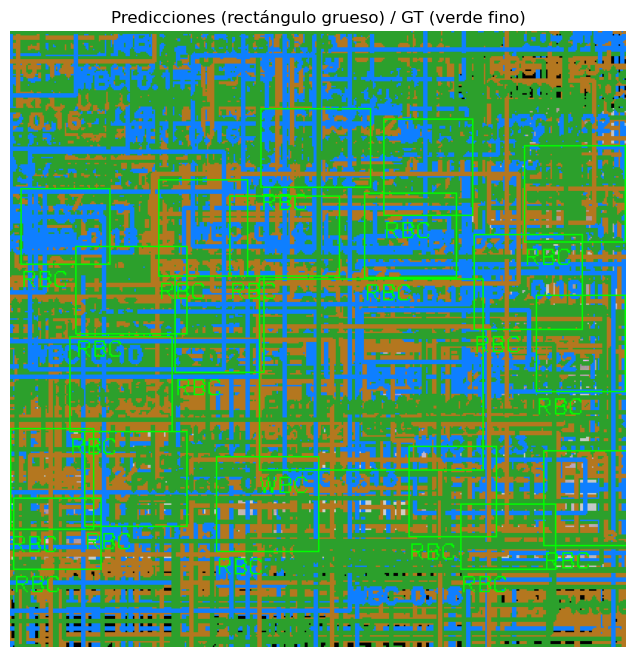

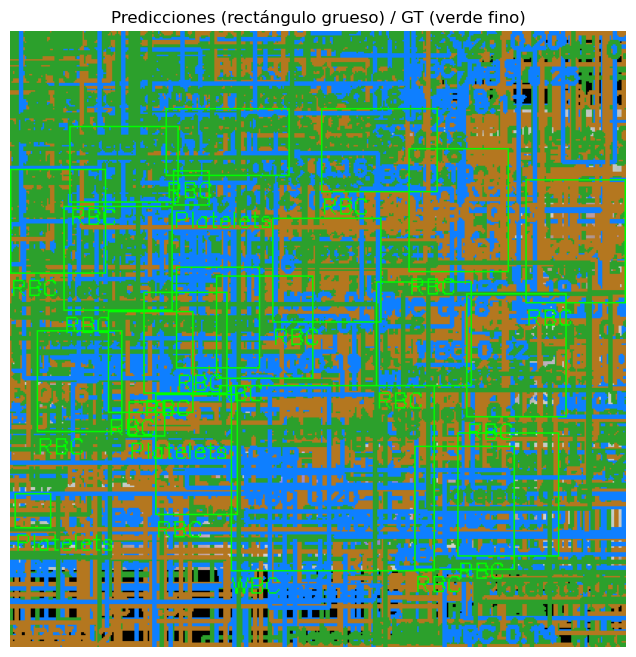

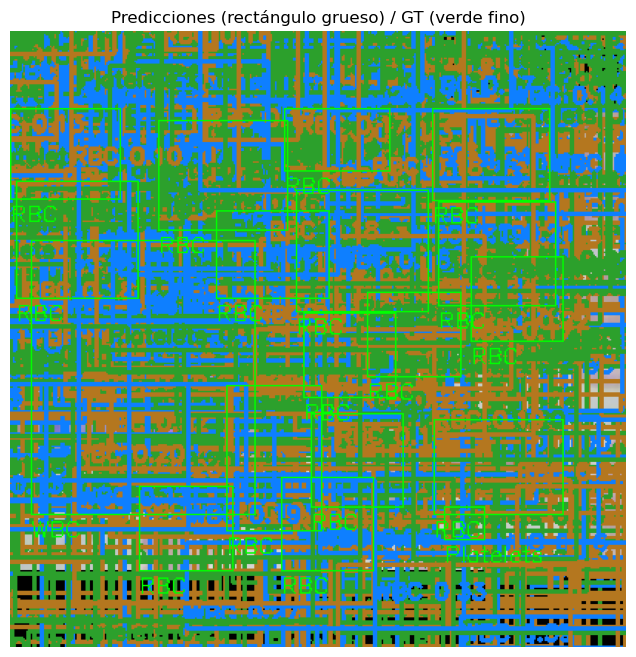

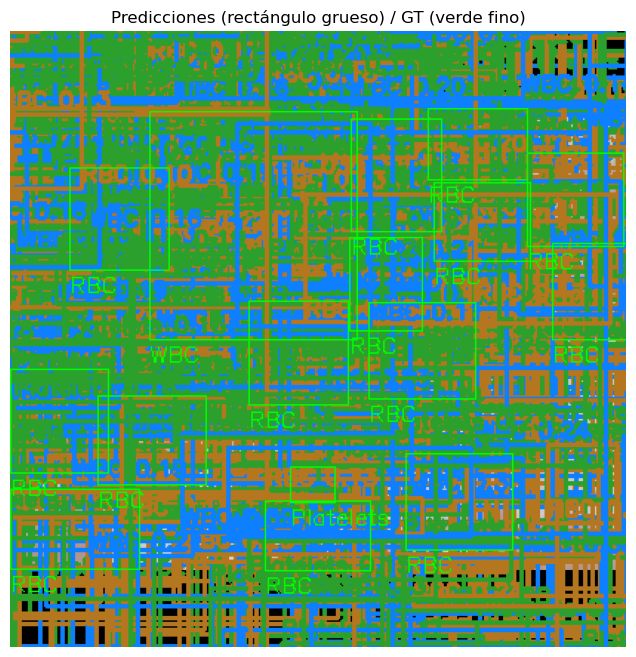

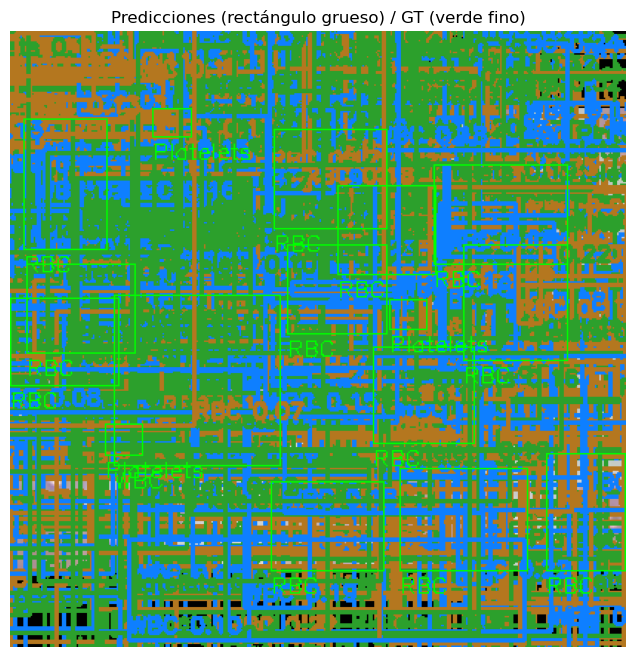

In [14]:
# Predicciones y visualización de resultados

import cv2
import matplotlib.pyplot as plt

def show_yolo_predictions(
    model, dataloader, anchors, num_classes, class_names,
    device, img_size=416, conf_threshold=0.3, iou_threshold=0.5,
    max_images=10, show_gt=True
):
    """
    Visualiza las predicciones del modelo YOLOv3 sobre imágenes reales.
    - model: tu modelo
    - dataloader: DataLoader (test o val)
    - anchors, num_classes: como en tu pipeline
    - class_names: lista de strings de nombres de clase
    - device: cpu o cuda
    - img_size: tamaño de entrada del modelo
    - conf_threshold: umbral de confianza para mostrar predicciones
    - iou_threshold: NMS
    - max_images: máximo de imágenes a visualizar
    - show_gt: si True, dibuja también las GT
    """
    model.eval()
    cmap = plt.get_cmap('tab10')
    with torch.no_grad():
        shown = 0
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_boxes = yolo_decode_outputs(
                outputs, anchors, num_classes, img_size=img_size,
                conf_thres=conf_threshold, iou_thres=iou_threshold, device=device
            )
            for i in range(images.shape[0]):
                img_np = images[i].cpu().permute(1,2,0).numpy()
                # Desnormaliza si usaste normalización estándar
                img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
                img_np = (img_np * 255).clip(0,255).astype(np.uint8)
                img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                # Dibuja predicciones
                for pb in pred_boxes[i]:
                    class_id = int(pb[0])
                    cx, cy, w, h, conf = pb[1], pb[2], pb[3], pb[4], pb[5]
                    x1 = int((cx - w/2) * img_bgr.shape[1])
                    y1 = int((cy - h/2) * img_bgr.shape[0])
                    x2 = int((cx + w/2) * img_bgr.shape[1])
                    y2 = int((cy + h/2) * img_bgr.shape[0])
                    color = tuple([int(255*x) for x in cmap(class_id)[:3]])
                    cv2.rectangle(img_bgr, (x1,y1), (x2,y2), color, 2)
                    label = f"{class_names[class_id]} {conf:.2f}"
                    cv2.putText(img_bgr, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # Dibuja GT (opcional)
                if show_gt and len(targets[i]) > 0:
                    for gt in targets[i]:
                        class_id = int(gt[0].item())
                        cx, cy, w, h = gt[1:].tolist()
                        x1 = int((cx - w/2) * img_bgr.shape[1])
                        y1 = int((cy - h/2) * img_bgr.shape[0])
                        x2 = int((cx + w/2) * img_bgr.shape[1])
                        y2 = int((cy + h/2) * img_bgr.shape[0])
                        color = (0,255,0)  # Verde para GT (puedes cambiarlo)
                        cv2.rectangle(img_bgr, (x1,y1), (x2,y2), color, 1)
                        cv2.putText(img_bgr, class_names[class_id], (x1, y2+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

                # Muestra la imagen
                plt.figure(figsize=(8,8))
                plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
                plt.title('Predicciones (rectángulo grueso) / GT (verde fino)')
                plt.axis('off')
                plt.show()
                shown += 1
                if shown >= max_images:
                    return

# Ejemplo de uso:

class_names = ['RBC', 'WBC', 'Platelets']
show_yolo_predictions(
    model, test_loader, anchors=ANCHORS, num_classes=NUM_CLASSES,
    class_names=class_names, device=device, img_size=416,
    conf_threshold=0.3, iou_threshold=0.5, max_images=5, show_gt=True
)